### 0. Importing modules and data

In [244]:
import pandas as pd
import os
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

raw_df = pd.read_csv('../data/raw/AB_NYC_2019.csv')
raw_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


### 1. Objective
Estimate the price of a property based on the characteristics collected in the dataset. So the target is the variable 'price'.

### 2.Exploration and superficial cleaning
#### 2.1 Problem dimensions

In [245]:
raw_df.shape

(48895, 16)

Our dataset have 48895 rows and 16 columns, so we have 16 variables or characteristics.

#### 2.2 Null values

In [246]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [247]:
raw_df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

There are no null values in almost any variable, and in those where there are, they are either few or easily replaceable or, initially, it is irrelevant. First it can be seen that number of null in last_reviews and reviews_per_month are the same. It makes sense that if a host doesn't have any reviews, this to variables came null. Let check if all null values in this two variables cames from this issue.

In [248]:
index_num_reviews_zero = raw_df[raw_df['number_of_reviews'] == 0].index.tolist()
index_last_review_null = raw_df[raw_df['last_review'].isnull()].index.tolist()
index_reviews_per_month_null = raw_df[raw_df['reviews_per_month'].isnull()].index.tolist()

if index_num_reviews_zero == index_last_review_null == index_reviews_per_month_null:
    print("All null valures came froma zero in number_of_reviews")
else:
    print("There are null values of unknown origin")

All null valures came froma zero in number_of_reviews


So it makes sense to replace null values in reviews_per_month by zero. Null values in last_review should be left as they are. Null values in name and host_name are not important.

In [249]:
# copy raw_df and modify the copy, leaving the original dataframe unmodified
df = raw_df.copy()

In [250]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

#### 2.3 Duplicates
Check if there are duplicates in the dataset

In [251]:
my_df = df.drop_duplicates(df.columns.difference(["host_id"]))
if len (raw_df) == len(my_df):
    print('There is no duplicates in raw data. Continue using df.')
else:
    print('Dropped duplicates from raw_df. Continue using my_df instead.')

There is no duplicates in raw data. Continue using df.


#### 2.4 Get a preliminary view of the distribution of values of the target

<Axes: xlabel='price', ylabel='Density'>

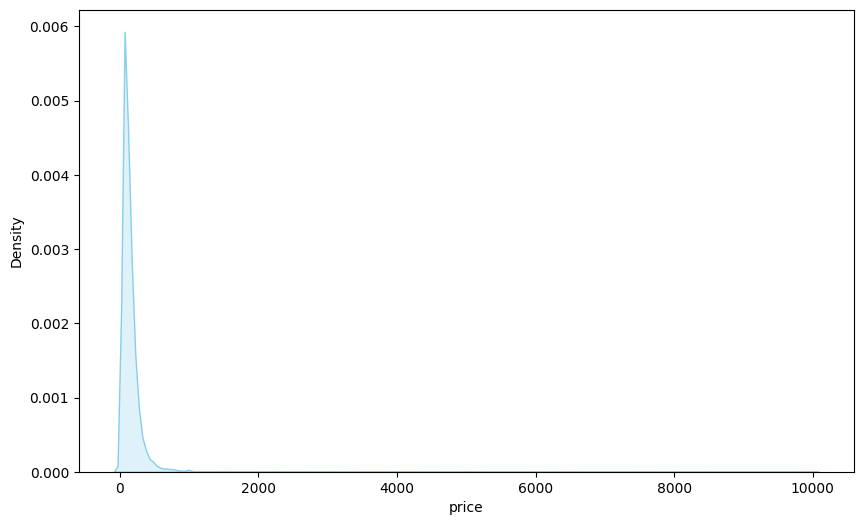

In [252]:
plt.figure(figsize=(10, 6))

sns.kdeplot(data=df['price'], color='skyblue', fill=True)

The distribution is asymmetric, skewed to the left, so the best descriptive statistic will be the mode. Moreover, we see that there are possible zeros in the target. It is considered that it does not make sense for there to be houses rented for free in a dataframe of rental properties, so the zeros in the price variable are considered errors and these rows are removed from the dataset.

In [253]:
# Check first how many rows have price=0
print((df['price'] == 0).sum())

11


As there are only a few rows with price equal to 0, we can drop them

In [254]:
df = df[df['price'] != 0]
df.shape

(48884, 16)

#### 2.5 Drop unuseful information

In [255]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


We can confidently drop columns id, name, host_name, host_id and last_review because there are not relevant for the analysis

In [256]:
df.drop(["last_review", "id", "host_id", "name", "host_name"], axis = 1, inplace = True)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


### 3. Univariate analysis

<Axes: xlabel='room_type', ylabel='Count'>

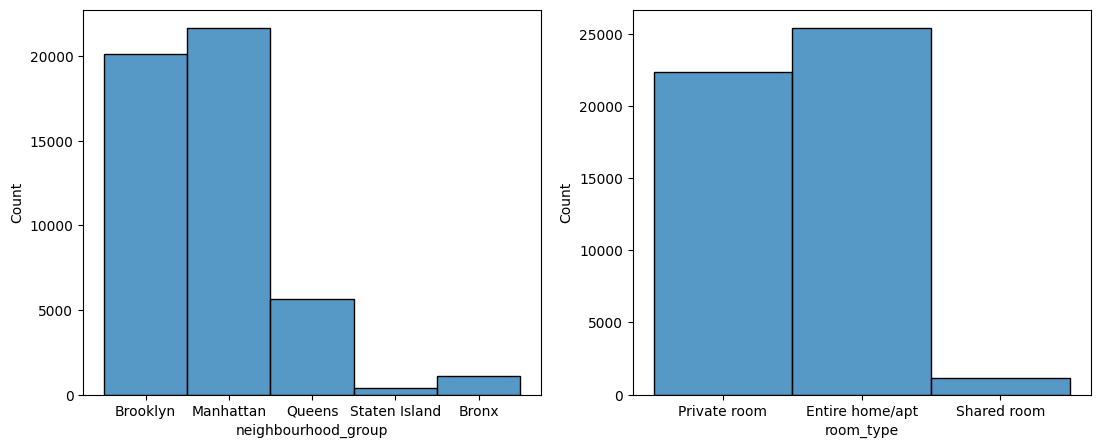

In [257]:
fig, axis = plt.subplots(1, 2, figsize=(13, 5))

sns.histplot(my_df, x="neighbourhood_group", ax=axis[0])
sns.histplot(my_df, x="room_type", ax=axis[1])

There is much more availability of entire homes or private rooms for rent. The majority of hostings are offered in Manhattan and Brooklyn.

<Axes: xlabel='number_of_reviews'>

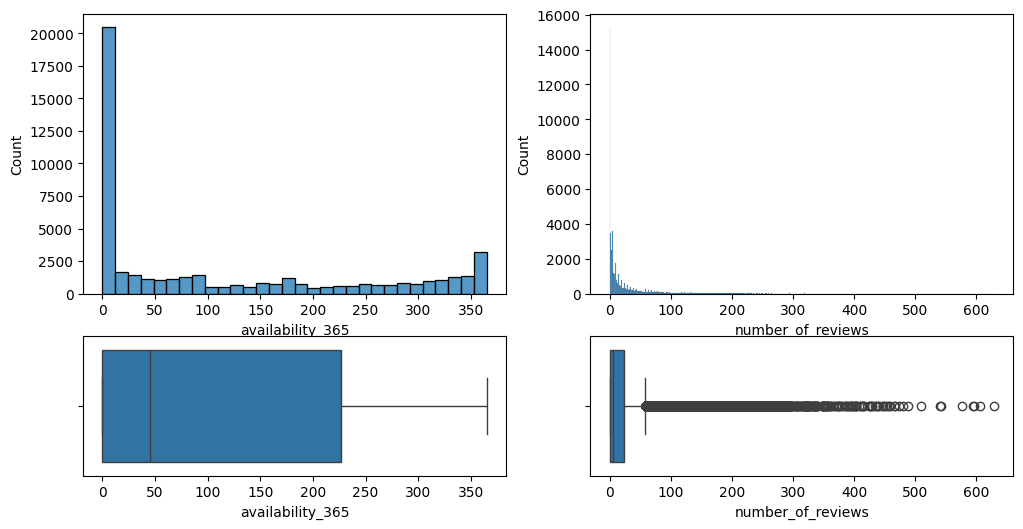

In [258]:
fig, axis = plt.subplots(2, 2, figsize = (12, 6),gridspec_kw={'height_ratios': [8, 4]})

sns.histplot(my_df, x = "availability_365", ax = axis[0,0])
sns.boxplot(my_df, x = "availability_365", ax = axis[1,0])
sns.histplot(my_df, x = "number_of_reviews", ax = axis[0,1])
sns.boxplot(my_df, x = "number_of_reviews", ax = axis[1,1])

The availability has a lot of dispersion, with the most common being below 25 days per year. Most hosts have fewer than 50 reviews, although there are many that seem to be very popular due to the large number of reviews they have.

### 4. Multivariate analysis

<Axes: xlabel='neighbourhood_group', ylabel='number_of_reviews'>

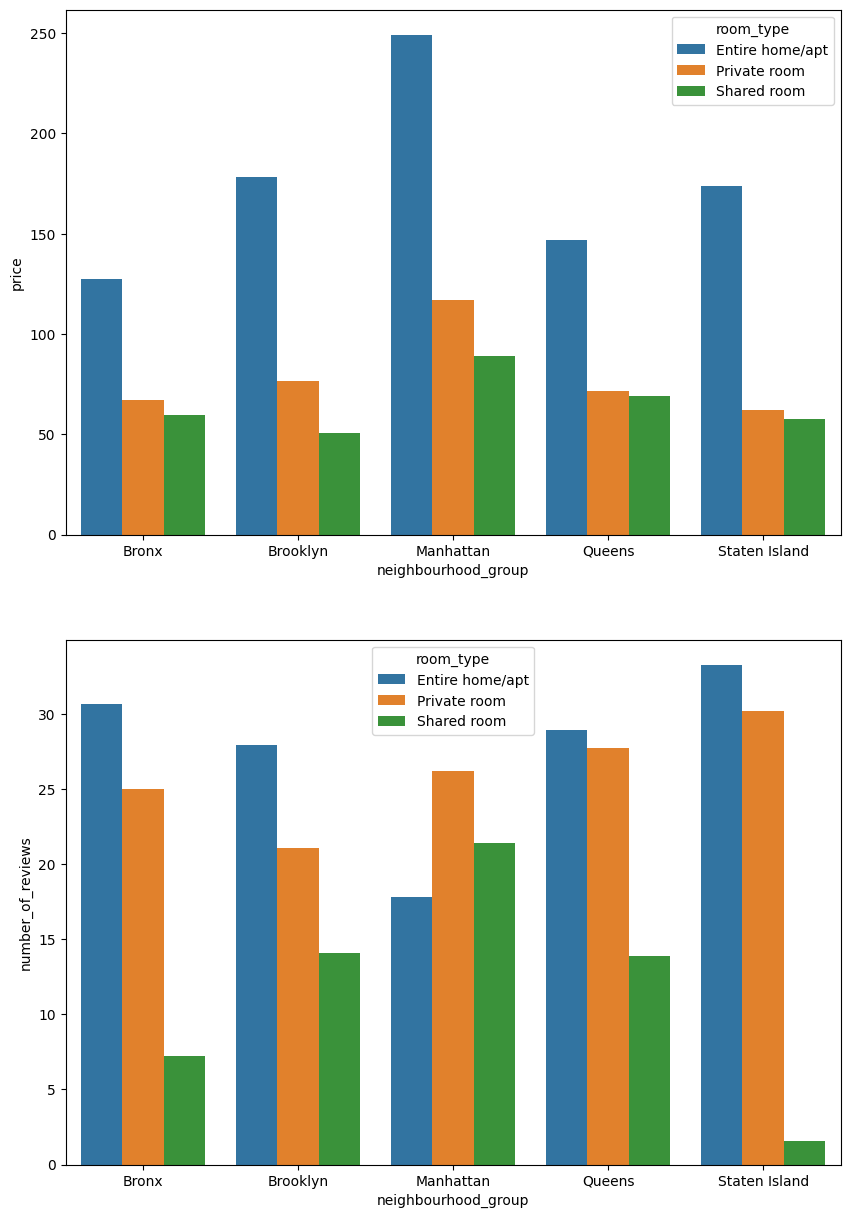

In [259]:
mean_prices = df.groupby(['neighbourhood_group', 'room_type'])['price'].mean().reset_index()
mean_reviews = df.groupby(['neighbourhood_group', 'room_type'])['number_of_reviews'].mean().reset_index()

fig, axis = plt.subplots(2, 1, figsize=(10, 15))
sns.barplot(data=mean_prices, x='neighbourhood_group', y='price', hue='room_type',ax = axis[0])
sns.barplot(data=mean_reviews, x='neighbourhood_group', y='number_of_reviews', hue='room_type',ax = axis[1])

In all districts, the most expensive type of room is the entire home, and the cheapest is the shared room. The most expensive district for all types of rooms is Manhattan. In all districts except Manhattan, the type of room that receives the most reviews is the entire home. The district that receives the most reviews for entire homes or private rooms is Staten Island. The district that receives the most reviews for shared rooms is Manhattan.

In [260]:
# Copy df to factorize categorics variables in a new dataframe
corr_df = df.copy()

<Axes: >

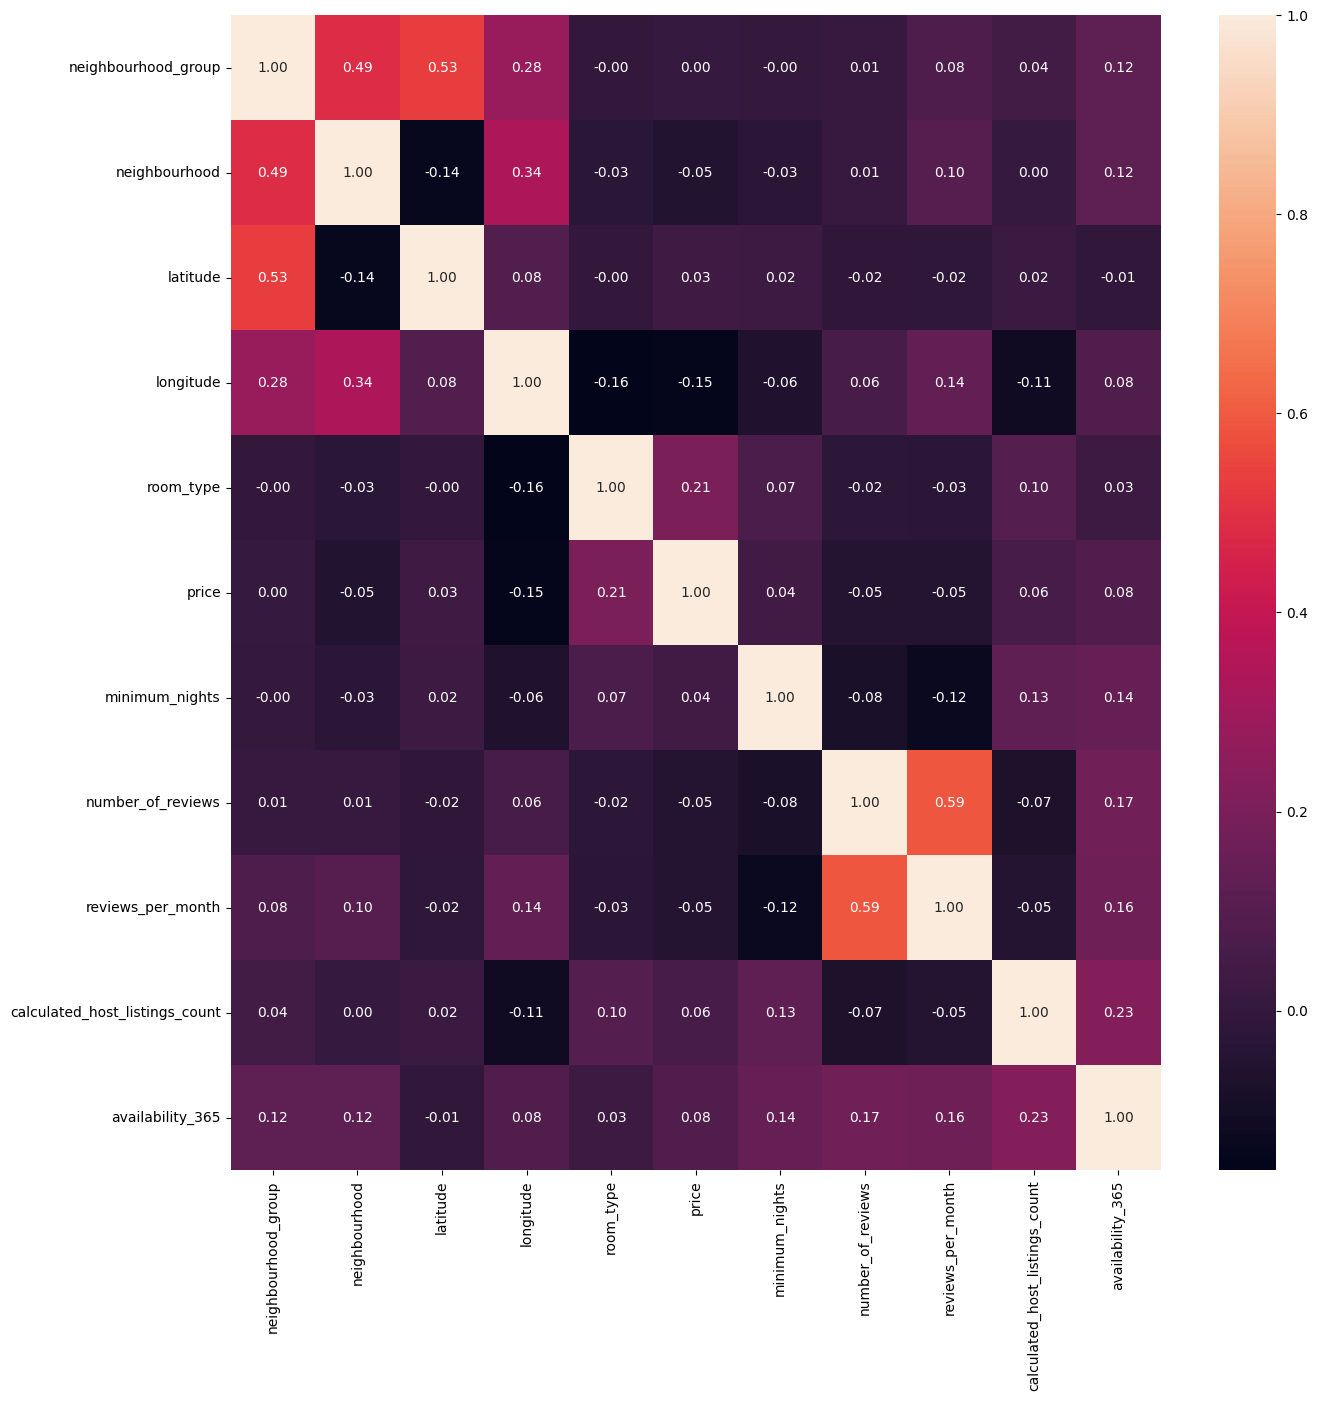

In [261]:
corr_df["neighbourhood"] = pd.factorize(corr_df["neighbourhood"])[0]
corr_df["neighbourhood_group"] = pd.factorize(corr_df["neighbourhood_group"])[0]
corr_df["room_type"] = pd.factorize(corr_df["room_type"])[0]

fig, axis = plt.subplots(figsize = (15, 15))

sns.heatmap(corr_df.corr(), annot = True, fmt = ".2f")

The correlation shows some trivial relationships, such as the neighborhood with the district and the coordinates, or the total number of reviews with the number of reviews per month. Other relationships are more interesting, such as the number of hosts of an owner with the availability of the host, or the price with the type of room. It also highlights the relationship between the type of room and the coordinates.

### 5. Feature engineering

#### 5.1 Outliers

In [262]:
corr_df.describe()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000
mean,0.786986,29.889534,40.728953,-73.952176,0.567118,152.755053,7.029887,23.271991,1.090800,7.144628,112.779498
std,0.844288,34.673859,0.054532,0.046159,0.541183,240.170260,20.512224,44.551331,1.597213,32.956185,131.627271
min,0.000000,0.000000,40.499790,-74.244420,0.000000,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,8.000000,40.690100,-73.983080,0.000000,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,1.000000,19.000000,40.723080,-73.955685,1.000000,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,1.000000,37.000000,40.763120,-73.936290,1.000000,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,4.000000,220.000000,40.913060,-73.712990,2.000000,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


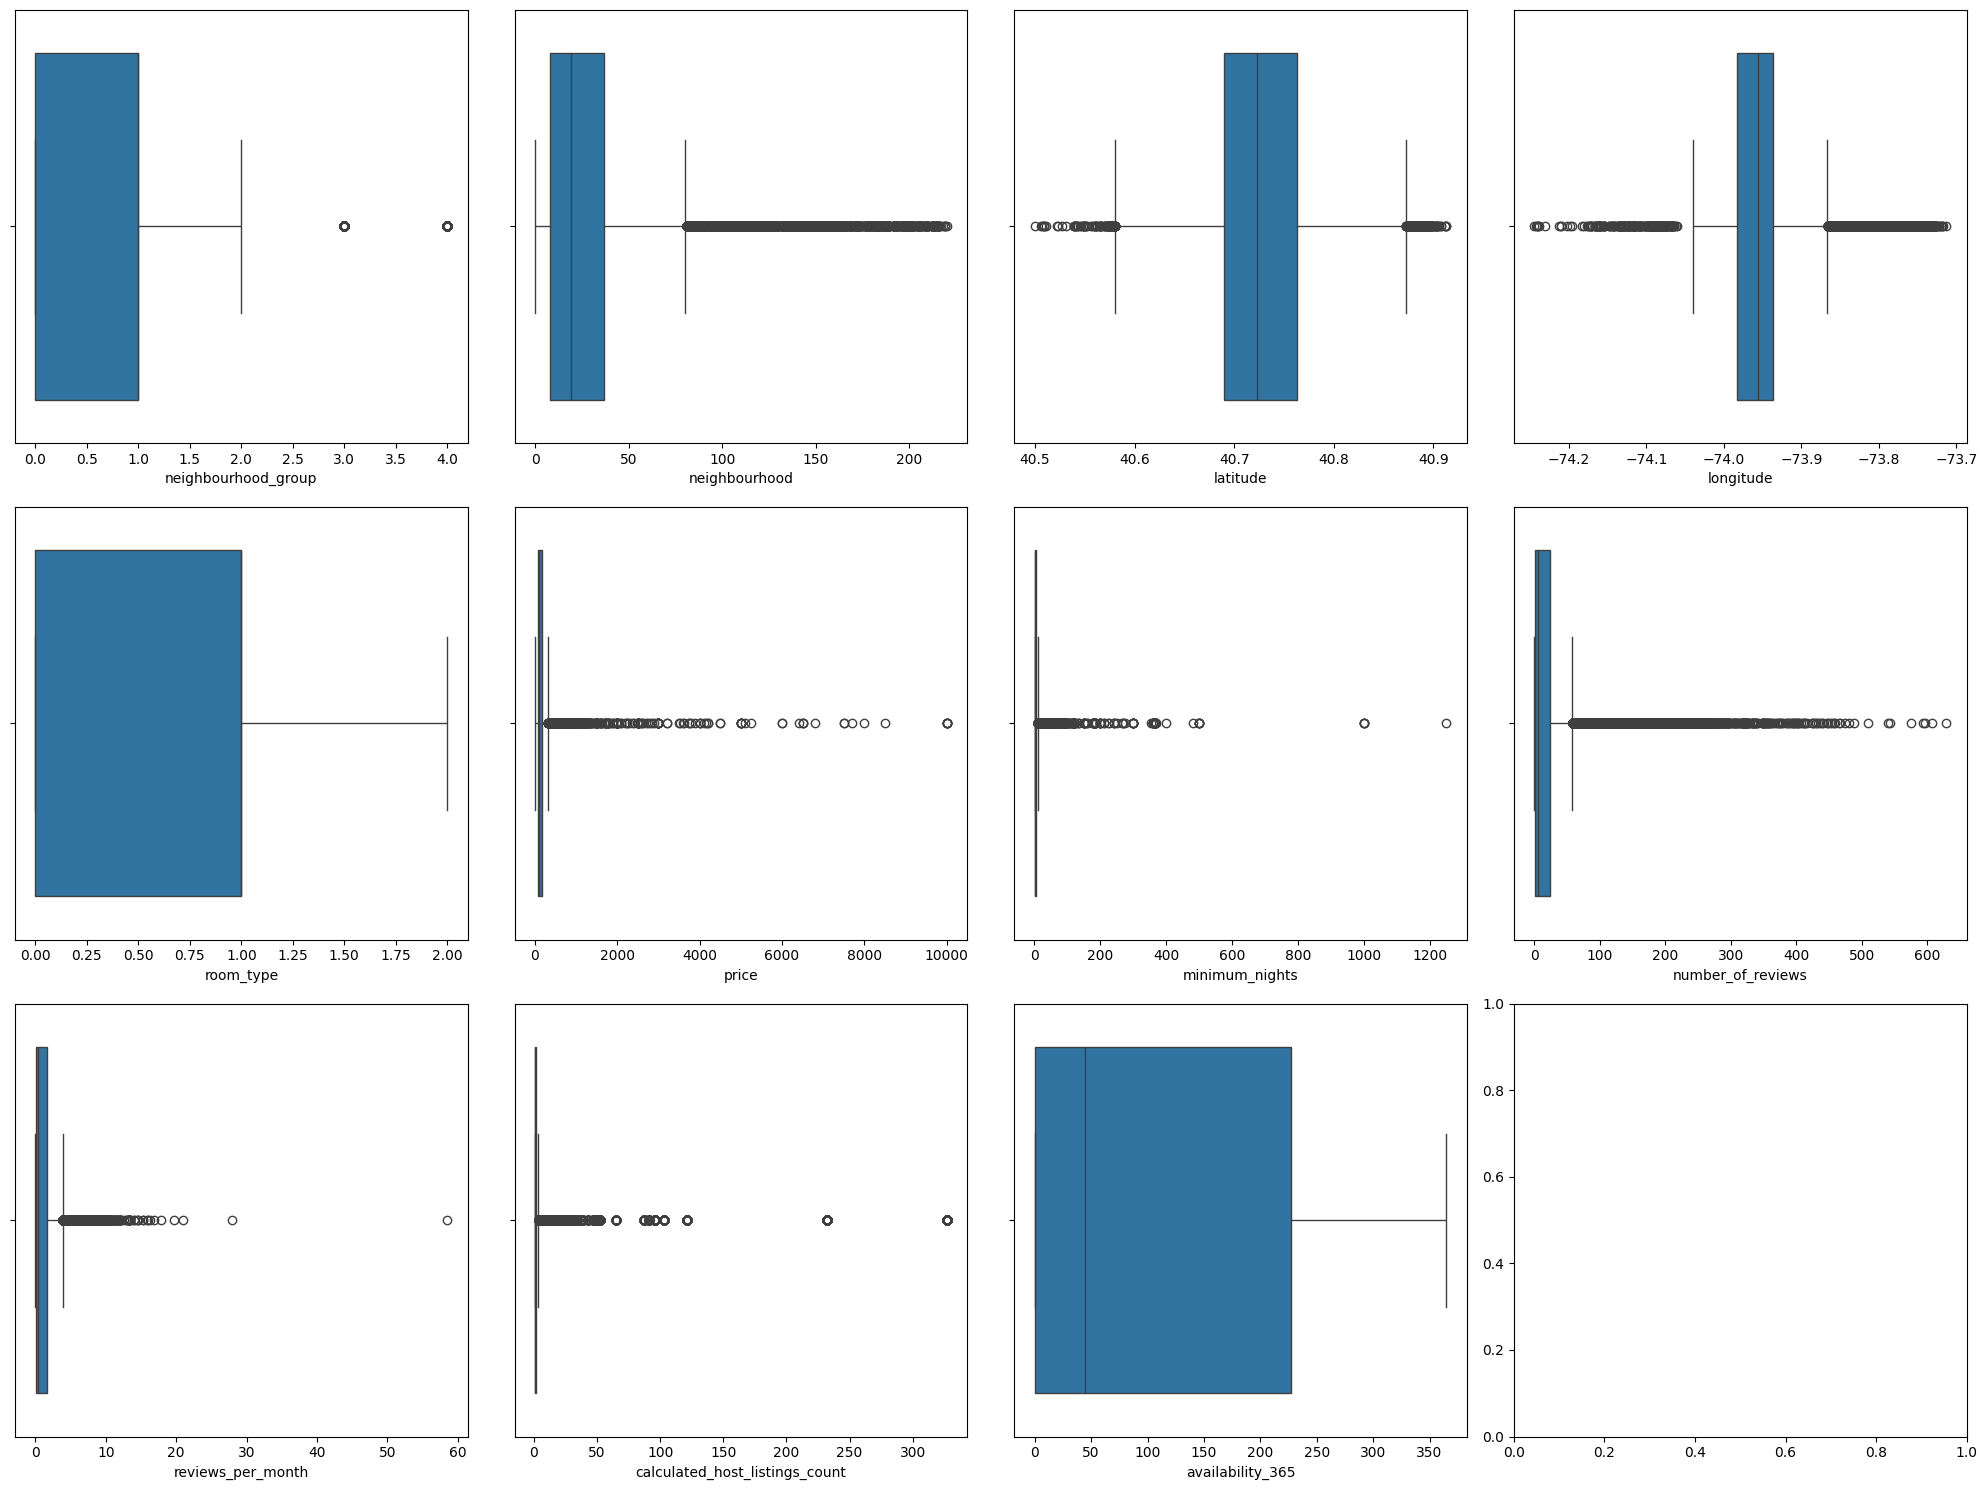

In [263]:
fig, axes = plt.subplots(nrows=corr_df.shape[1] // 4 + 1, ncols=4, figsize=(20, 5 * (corr_df.shape[1] // 4 + 1)))

for i, column in enumerate(corr_df.columns):
    sns.boxplot(x=corr_df[column], ax=axes[i // 4, i % 4])

plt.tight_layout()


In general, our data across different variables are very dispersed, so we will limit outlier treatment to those variables where we observe very atypical values far from the rest. In categorical variables, it doesn't make sense to look for outliers. Neither in longitude and latitude, since, although they are numerical variables, they actually have a categorical meaning. 

Outliers in variables related to reviews are not modified, as they indicate which accommodations have more reviews than the rest, interpreted as the most desired and, therefore, relevant for the model. 

If there are values above 365 in availability, since it doesn't make sense for the accommodation to be available for more days than there are in a year, it is considered an error and this value is replaced by the maximum of 365. At the same time, availability equal to 0 must be an error, as it doesn't make sense for the accommodation to be on a rental website if it cannot be rented. These zeros are also replaced by one, because is the minimal.

We will study the outliers in minimum nights and replace them with the mode.

In [264]:
# Check if there is availability_365>365
print((corr_df['availability_365'] > 365).sum())
print((corr_df['availability_365'] == 0).sum())

0
17530


In [265]:
ava_replace_func = lambda x: x if x != 0 else 1
corr_df['availability_365'] = corr_df['availability_365'].apply(ava_replace_func)
print((corr_df['availability_365'] == 0).sum())


0


In [266]:
descr_minN = corr_df["minimum_nights"].describe()
descr_minN

count    48884.000000
mean         7.029887
std         20.512224
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

In [267]:
minN_iqr = descr_minN["75%"] - descr_minN["25%"]
upper_l = descr_minN["75%"] + 3*minN_iqr
lower_l = 1

print(lower_l, upper_l)
outliers = corr_df[corr_df['minimum_nights'] >= upper_l]
outliers

1 17.0


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
6,0,6,40.68688,-73.95596,0,60,45,49,0.40,1,1
14,1,11,40.73530,-74.00525,1,120,90,27,0.22,1,1
36,0,6,40.68876,-73.94312,0,35,60,0,0.00,1,365
45,0,24,40.65944,-73.96238,1,150,29,11,0.49,1,95
55,0,12,40.70881,-73.95930,1,150,30,105,0.90,1,30
...,...,...,...,...,...,...,...,...,...,...,...
48810,1,8,40.79952,-73.96003,0,75,30,0,0.00,1,90
48843,0,6,40.69635,-73.93743,0,45,29,0,0.00,2,341
48871,1,2,40.82233,-73.94687,0,35,29,0,0.00,2,31
48879,0,12,40.71728,-73.94394,1,120,20,0,0.00,1,22


In [268]:
minN_mode = corr_df['minimum_nights'].mode()

replace_func = lambda x: x if lower_l <= x <= upper_l else minN_mode
corr_df['minimum_nights'] = corr_df['minimum_nights'].apply(replace_func)


#### 5.2 Inference of new features
We can calculate the maximum income per property by multiplying the available nights by the price per night

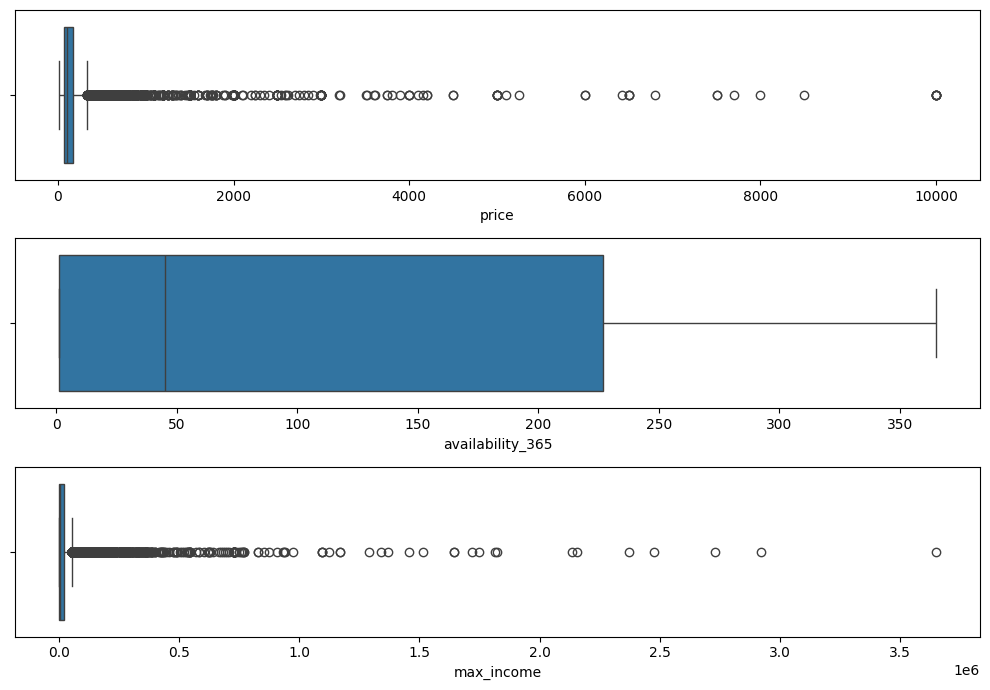

In [269]:
corr_df['max_income'] = corr_df['availability_365']*corr_df['price']
fig, axis = plt.subplots(3, 1, figsize = (10, 7))

sns.boxplot(corr_df, x = "price",ax = axis[0])
sns.boxplot(corr_df, x = "availability_365",ax = axis[1])
sns.boxplot(corr_df, x = "max_income",ax = axis[2])
plt.tight_layout()

The maximum income if more influenced by price than availability

Save all dataframes as csv

In [270]:
df.to_csv('../data/processed/AB_NYC_2019_precleaned.csv', index=False)
corr_df.to_csv('../data/processed/AB_NYC_2019_cleaned.csv', index=False)
outliers.to_csv('../data/processed/AB_NYC_2019_minNights_Outliers.csv', index=False)

#### 5.3 Feature scaling
First, we divide the data

In [271]:
corr_df.columns

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'max_income'],
      dtype='object')

In [272]:
predictors = ['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'max_income']
target = 'price'

X = corr_df[predictors]
Y = corr_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

X_train.to_csv('../data/processed/AB_NYC_2019_Xtrain.csv', index=False)
X_test.to_csv('../data/processed/AB_NYC_2019_Xtest.csv', index=False)
y_train.to_csv('../data/processed/AB_NYC_2019_ytrain.csv', index=False)
y_test.to_csv('../data/processed/AB_NYC_2019_ytest.csv', index=False)

#### 5.4 Normalize

In [273]:
from sklearn.preprocessing import StandardScaler
from pickle import dump

scaler = StandardScaler()
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, index = X_train.index, columns = predictors)

X_test_norm = scaler.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, index = X_test.index, columns = predictors)

dump(scaler, open("../data/processed/normalizer.sav", "wb"))
X_train_norm.to_csv('../data/processed/AB_NYC_2019_norm_Xtrain.csv', index=False)
X_test_norm.to_csv('../data/processed/AB_NYC_2019_norm_Xtest.csv', index=False)

X_train_norm.head()

/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/_array_api.py:521: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/_array_api.py:521: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/_array_api.py:521: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,max_income
22111,0.251684,0.984911,-0.132127,-0.968137,-1.049199,1.317855,0.537860,0.898660,-0.187991,-0.558071,-0.249259
38200,0.251684,-0.658798,0.712497,-0.836725,-1.049199,-0.307343,-0.409377,-0.235456,-0.187991,-0.268950,-0.161780
16707,0.251684,-0.053221,0.918976,0.076636,0.795403,-0.307343,-0.386823,-0.570113,-0.187991,-0.854801,-0.325599
5157,0.251684,-0.312754,-0.045390,-0.697262,0.795403,-0.307343,3.514889,1.177541,-0.187991,0.499505,0.050381
22136,1.439564,0.754215,0.824172,0.540278,-1.049199,0.911556,0.537860,0.415266,-0.187991,-0.824367,-0.323551


### 6.Feature selection

In [274]:
from sklearn.feature_selection import f_classif, SelectKBest, mutual_info_classif #After trying both methods, I find the better the ANOVA's selection

selection_model = SelectKBest(f_classif, k = 7)
selection_model.fit(X_train_norm, y_train)
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train_norm), columns = X_train_norm.columns.values[ix])

dump(selection_model, open("../data/processed/selection_model.sav", "wb"))
X_train_sel.to_csv('../data/processed/AB_NYC_2019_norm_Xtrain.csv', index=False)

X_train_sel.head()

,neighbourhood,longitude,room_type,number_of_reviews,calculated_host_listings_count,availability_365,max_income
0,0.984911,-0.968137,-1.049199,0.537860,-0.187991,-0.558071,-0.249259
1,-0.658798,-0.836725,-1.049199,-0.409377,-0.187991,-0.268950,-0.161780
2,-0.053221,0.076636,0.795403,-0.386823,-0.187991,-0.854801,-0.325599
3,-0.312754,-0.697262,0.795403,3.514889,-0.187991,0.499505,0.050381
4,0.754215,0.540278,-1.049199,0.537860,-0.187991,-0.824367,-0.323551
